In [2]:
import pandas as pd
import json
from pathlib import Path

In [3]:
source_csv_dir = Path("/home/heh/github/speechbrain/recipes/SLURP/direct/results/1986")
data_dir = ("/home/heh/datasets/slurp-speechbrain")

csv_list = list(source_csv_dir.glob("*.csv"))
print(csv_list)

[PosixPath('/home/heh/github/speechbrain/recipes/SLURP/direct/results/1986/train-type=direct.csv'), PosixPath('/home/heh/github/speechbrain/recipes/SLURP/direct/results/1986/train_synthetic-type=direct.csv'), PosixPath('/home/heh/github/speechbrain/recipes/SLURP/direct/results/1986/train_real-type=direct.csv'), PosixPath('/home/heh/github/speechbrain/recipes/SLURP/direct/results/1986/devel-type=direct.csv'), PosixPath('/home/heh/github/speechbrain/recipes/SLURP/direct/results/1986/test-type=direct.csv')]


In [4]:
import json
def load_manifest(filepath):
    data = []
    with open(filepath, "r") as fin:
        for line in fin.readlines():
            datum = json.loads(line)
            data.append(datum)

    return data

In [7]:
train1 = "../manifests/train_real_asr.json"
train2 = "../manifests/train_synthetic_asr.json"
data = load_manifest(train1) + load_manifest(train2)
durations = [d["duration"] for d in data]
print(len(data), "samples")
print(f"{sum(durations) / 3600} hours")

119881
84.66974640833308


In [8]:
filepath = "../manifests/dev_asr.json"
data = load_manifest(filepath)
durations = [d["duration"] for d in data]
print(len(data), "samples")
print(f"{sum(durations) / 3600} hours")

8690 samples
6.902020319444427 hours


In [9]:
filepath = "../manifests/test_asr.json"
data = load_manifest(filepath)
durations = [d["duration"] for d in data]
print(len(data), "samples")
print(f"{sum(durations) / 3600} hours")

13078 samples
10.253316301110935 hours


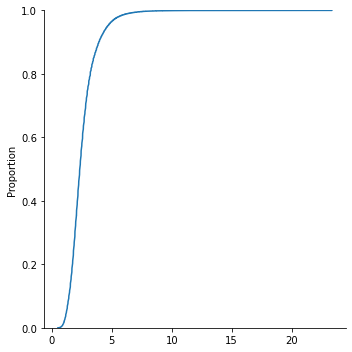

In [6]:
import seaborn as sns
sns.displot(durations, kind="ecdf")

In [1]:
max_t = 8
min_t = 0.1
filtered = [t for t in durations if min_t <= t <= max_t]
print(f"{len(filtered)/len(durations)}")
print(f"{sum(durations) / 3600}")

NameError: name 'durations' is not defined